In [1]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [35]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


import joblib
import pickle


import warnings
warnings.filterwarnings('ignore')


In [36]:
# read the dataset
df = pd.read_csv('/content/gdrive/MyDrive/Blossom_fellowship(Data_Science)/group_capstone/Data.csv')
df.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.0,32.0,18000.0,6000.0,34.0,NaN,97.0,355.0,6.0,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.0,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,0.0,NaN,2.0,NO,40,"Data: 100 F=40MB,24H",22.0,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.0,3.0,1500.0,500.0,3.0,NaN,30.0,30.0,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.0,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,19.0,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.0,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.0,166.0,3.0,1.0,1.0,3.0,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         400000 non-null  object 
 1   REGION          242480 non-null  object 
 2   TENURE          400000 non-null  object 
 3   MONTANT         259723 non-null  float64
 4   FREQUENCE_RECH  259723 non-null  float64
 5   REVENUE         265337 non-null  float64
 6   ARPU_SEGMENT    265337 non-null  float64
 7   FREQUENCE       265337 non-null  float64
 8   DATA_VOLUME     203146 non-null  float64
 9   ON_NET          254181 non-null  float64
 10  ORANGE          233683 non-null  float64
 11  TIGO            160614 non-null  float64
 12  ZONE1           31690 non-null   float64
 13  ZONE2           25513 non-null   float64
 14  MRG             400000 non-null  object 
 15  REGULARITY      400000 non-null  int64  
 16  TOP_PACK        232671 non-null  object 
 17  FREQ_TOP_P

In [38]:
# check missing values
df.isnull().sum()

,0
user_id,0
REGION,157520
TENURE,0
MONTANT,140277
FREQUENCE_RECH,140277
REVENUE,134663
ARPU_SEGMENT,134663
FREQUENCE,134663
DATA_VOLUME,196854
ON_NET,145819


### Drop Columns not Needed

In [39]:
# drop columns of no effect/use: user_id, tigo, zone1, zone2 columns
df = df.drop(columns=['user_id', 'TIGO', 'ZONE1', 'ZONE2'], axis=1)
df.columns

Index(['REGION', 'TENURE', 'MONTANT', 'FREQUENCE_RECH', 'REVENUE',
       'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'MRG',
       'REGULARITY', 'TOP_PACK', 'FREQ_TOP_PACK', 'CHURN'],
      dtype='object')

 Distribution of numerical columns: ['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'DATA_VOLUME', 'ON_NET', 'ORANGE', 'REGULARITY', 'FREQ_TOP_PACK', 'CHURN']


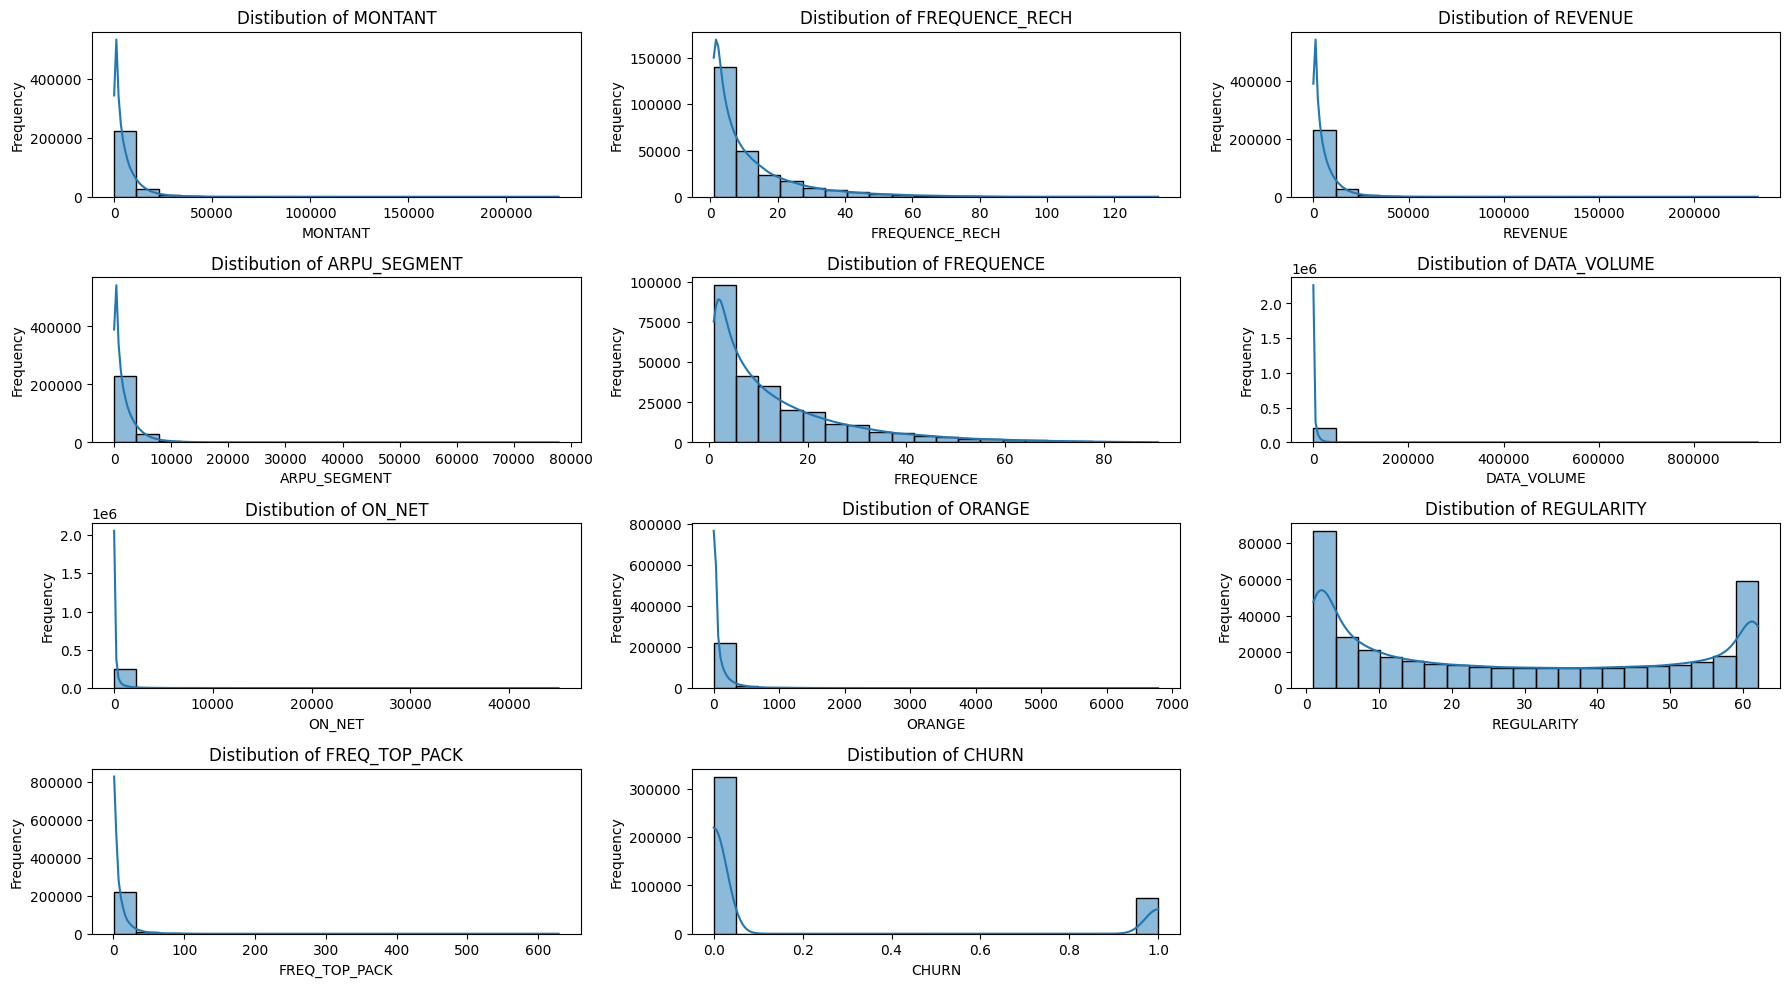

In [40]:
# distribution of numerical features
numerical_columns = df.select_dtypes(include=['float', 'int']).columns.tolist()
print(" Distribution of numerical columns:", numerical_columns)

# create the figure
plt.figure(figsize=(18,12))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 3, i)
    sns.histplot(df[column], kde=True, bins=20)
    plt.title(f'Distibution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Data Splitting

In [5]:
# defining features and targets:
X = df.drop('CHURN', axis=1)
y = df['CHURN']

In [6]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Main Preprocessing Steps (1.0)

#### Handle Missing Values

In [7]:
# impute numerical columns with median
numerical_cols = X_train.select_dtypes(include=['float', 'int']).columns

median_imputer = SimpleImputer(strategy='median')
# fit imputer on training data
median_imputer.fit(X_train[numerical_cols])

# transform the training and test data
X_train[numerical_cols] = median_imputer.transform(X_train[numerical_cols])
X_test[numerical_cols] = median_imputer.transform(X_test[numerical_cols])

In [8]:
# impute categorical columns with mode(mos frequent)

categorical_cols = X_train.select_dtypes(include=['object']).columns

mode_imputer = SimpleImputer(strategy='most_frequent')
# fit on the training data
mode_imputer.fit(X_train[categorical_cols])

# transform the train and test data
X_train[categorical_cols] = mode_imputer.transform(X_train[categorical_cols])
X_test[categorical_cols] = mode_imputer.transform(X_test[categorical_cols])

#### Label Encoding

In [9]:
# functoin to perform label encoding
def fit_and_transform(le, train_data, test_data):
    # fit encoder on the train data
    le.fit(train_data)
    # Transform train data
    train_transformed = le.transform(train_data)

    # Transform test data, handling unseen labels if any
    test_transformed = np.array([le.transform([val])[0] if val in le.classes_ else -1 for val in test_data])

    return train_transformed, test_transformed

In [10]:
for col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[col], X_test[col] = fit_and_transform(le, X_train[col], X_test[col])

#### Scaling Data

In [11]:
scaler = StandardScaler()

# fit and transform the train set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# transform the test set
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Model Training(XGBoost)

In [25]:
xg_model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=3,
                          learning_rate=0.1,
                          n_estimators=100)

# make predictions
xg_model.fit(X_train_scaled, y_train)

# evaluate model
y_pred = xg_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Classification report:\n {report}")


Accuracy: 0.87
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     32585
           1       0.67      0.61      0.64      7415

    accuracy                           0.87     40000
   macro avg       0.79      0.77      0.78     40000
weighted avg       0.87      0.87      0.87     40000



#### Preprocessing 1.1 - Applying smote

In [14]:
# applying smote
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

In [15]:
print("Original training set target distribution: ", y_train.value_counts())
print("resampled training set targets distribution: ", y_train_resampled.value_counts())

Original training set target distribution:  CHURN
0    292571
1     67429
Name: count, dtype: int64
resampled training set targets distribution:  CHURN
0    292571
1    292571
Name: count, dtype: int64


In [24]:
# create the model
xg_model2 = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=3,
                          learning_rate=0.1,
                          n_estimators=100)

#------------------------------------------------------
# make predictions
xg_model2.fit(X_train_resampled, y_train_resampled)

# evaluate model
y_pred = xg_model2.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Classification report:\n {report}")


Accuracy: 0.83
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.82      0.89     32585
           1       0.52      0.86      0.65      7415

    accuracy                           0.83     40000
   macro avg       0.74      0.84      0.77     40000
weighted avg       0.88      0.83      0.84     40000



### Preprocessing 1.2  
- remove outliers
- build model

In [17]:
# removing outliers

# Define a function to remove outliers based on IQR
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# Remove outliers from the scaled training set
X_train_cleaned = remove_outliers(X_train_scaled)

# Align the target variable with the cleaned feature set
y_train_cleaned = y_train[X_train_scaled.index.isin(X_train_cleaned.index)]

In [23]:
# build the model
xg_model3 = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=3,
                          learning_rate=0.1,
                          n_estimators=100)

# fit the model
xg_model3.fit(X_train_cleaned, y_train_cleaned)

# predict and evaluate model
y_pred3 = xg_model3.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred3)
report = classification_report(y_test, y_pred3)

print(f"Accuracy: {accuracy:.2f}")
print(f"Classification report:\n {report}")


Accuracy: 0.87
Classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     32585
           1       0.67      0.60      0.63      7415

    accuracy                           0.87     40000
   macro avg       0.79      0.77      0.78     40000
weighted avg       0.87      0.87      0.87     40000



### Preprocessing 1.3  
- apply smote on set with no outliers
- build model

In [19]:
# using smote on cleaned set
smote4 = SMOTE()
X_train_clean_resampled, y_train_clean_resampled = smote4.fit_resample(X_train_cleaned, y_train_cleaned)

In [22]:
# create the mode
model4 = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=3,
                          learning_rate=0.1,
                          n_estimators=100)

# fit the model
model4.fit(X_train_clean_resampled, y_train_clean_resampled)

# make predictions
pred4 = model4.predict(X_test_scaled)
accuracy4 = accuracy_score(y_test, pred4)
report4 = classification_report(y_test, pred4)
# f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy4:.2f}")
print(f"Classification report:\n {report4}")
# print(f"F1-score: {f1:.2f}")

Accuracy: 0.86
Classification report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92     32585
           1       0.62      0.72      0.66      7415

    accuracy                           0.86     40000
   macro avg       0.77      0.81      0.79     40000
weighted avg       0.88      0.86      0.87     40000



## Hyperparameter Tuning...  
____  
***Using Randomized SeachCV***

In [26]:
param_dist1 = {
    'max_depth': randint(3, 10),  # Random integers between 3 and 10
    'learning_rate': uniform(0.01, 0.3),  # Uniform distribution between 0.01 and 0.3
    'n_estimators': randint(50, 300),  # Random integers between 50 and 300
    'subsample': uniform(0.5, 0.5),  # Uniform distribution between 0.5 and 1.0
    'colsample_bytree': uniform(0.5, 0.5),  # Uniform distribution between 0.5 and 1.0
    'gamma': uniform(0, 5)  # Uniform distribution between 0 and 5
}

param_dist2 = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [27]:
# create the model
MODEL = xgb.XGBClassifier(objective='binary:logistic',
                          use_label_encoder=False,
                          eval_metric='logloss',
                          seed=42)

### 1st Parameter Distibutions...

In [28]:
# use randomized search cv1
random_search1 = RandomizedSearchCV(estimator=MODEL,
                                   param_distributions=param_dist1,
                                   n_iter=100,  # Number of random combinations to try
                                   scoring='f1',  # Use F1 score as the evaluation metric
                                   cv=5,  # 5-fold cross-validation
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)  # Use all available cores

#### set1

In [29]:
random_search1.fit(X_train_scaled, y_train)

# get the best params and best model
best_paramsA = random_search1.best_params_
best_modelA = random_search1.best_estimator_

print(f"Best Hyperparameters: {best_paramsA}")
print(f"Best Model: {best_modelA}")

# evaluate best model on test set
best_y_predA = best_modelA.predict(X_test_scaled)
best_accuracyA = accuracy_score(y_test, best_y_predA)
reportA = classification_report(y_test, best_y_predA)

# print results
print(f"Best model accuracy: {best_accuracyA}")
print(f"classification report: {reportA}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'colsample_bytree': 0.7001114464360124, 'gamma': 2.3885744544011382, 'learning_rate': 0.034867396508006264, 'max_depth': 3, 'n_estimators': 215, 'subsample': 0.718167915803278}
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7001114464360124, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.3885744544011382, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.034867396508006264,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n

#### set2

In [ ]:
random_search1.fit(X_train_resampled, y_train_resampled)

# get the best params and best model
best_paramsB = random_search1.best_params_
best_modelB = random_search1.best_estimator_

print(f"Best Hyperparameters: {best_paramsB}")
print(f"Best Model: {best_modelB}")

# evaluate best model on test set
best_y_predB = best_modelB.predict(X_test_scaled)
best_accuracyB = accuracy_score(y_test, best_y_predB)
reportB = classification_report(y_test, best_y_predB)

# print results
print(f"Best model accuracy: {best_accuracyB}")
print(f"classification report:\n {reportB}")

#### set3

In [ ]:
random_search1.fit(X_train_cleaned, y_train_cleaned)

# get the best params and best model
best_paramsC = random_search1.best_params_
best_modelC = random_search1.best_estimator_

print(f"Best Hyperparameters: {best_paramsC}")
print(f"Best Model: {best_modelC}")

# evaluate best model on test set
best_y_predC = best_modelC.predict(X_test_scaled)
best_accuracyC = accuracy_score(y_test, best_y_predC)
reportC = classification_report(y_test, best_y_predC)

# print results
print(f"Best model accuracy: {best_accuracyC}")
print(f"classification report:\n {reportC}")

#### set4

In [ ]:
random_search1.fit(X_train_clean_resampled, y_train_clean_resampled)

# get the best params and best model
best_paramsD = random_search1.best_params_
best_modelD = random_search1.best_estimator_

print(f"Best Hyperparameters: {best_paramsD}")
print(f"Best Model: {best_modelD}")

# evaluate best model on test set
best_y_predD = best_modelD.predict(X_test_scaled)
best_accuracyD = accuracy_score(y_test, best_y_predD)
reportD = classification_report(y_test, best_y_predD)

# print results
print(f"Best model accuracy: {best_accuracyD}")
print(f"classification report:\n {reportD}")

### 2nd Parameter Distributions...

In [32]:
# randomized search cv 2
random_search2 = RandomizedSearchCV(estimator=MODEL,
                                   param_distributions=param_dist2,
                                   n_iter=100,  # Number of random combinations to try
                                   scoring='f1',  # Use F1 score as the evaluation metric
                                   cv=5,  # 5-fold cross-validation
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)  # Use all available cores

#### set2A

In [ ]:
random_search2.fit(X_train_scaled, y_train)

# get the best params and best model
best_params2A = random_search1.best_params_
best_model2A = random_search1.best_estimator_

print(f"Best Hyperparameters: {best_params2A}")
print(f"Best Model: {best_model2A}")

# evaluate best model on test set
best_y_pred2A = best_model2A.predict(X_test_scaled)
best_accuracy2A = accuracy_score(y_test, best_y_pred2A)
report2A = classification_report(y_test, best_y_pred2A)

# print results
print(f"Best model accuracy: {best_accuracy2A}")
print(f"classification report:\n {report2A}")

#### set2B

In [33]:
random_search2.fit(X_train_resampled, y_train_resampled)

# get the best params and best model
best_params2B = random_search1.best_params_
best_model2B = random_search1.best_estimator_

print(f"Best Hyperparameters: {best_params2B}")
print(f"Best Model: {best_model2B}")

# evaluate best model on test set
best_y_pred2B = best_model2B.predict(X_test_scaled)
best_accuracy2B = accuracy_score(y_test, best_y_pred2B)
report2B = classification_report(y_test, best_y_pred2B)

# print results
print(f"Best model accuracy: {best_accuracy2B}")
print(f"classification report:\n {report2B}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'colsample_bytree': 0.7001114464360124, 'gamma': 2.3885744544011382, 'learning_rate': 0.034867396508006264, 'max_depth': 3, 'n_estimators': 215, 'subsample': 0.718167915803278}
Best Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7001114464360124, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=2.3885744544011382, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.034867396508006264,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n

#### set2C

In [ ]:
random_search2.fit(X_train_cleaned, y_train_cleaned)

# get the best params and best model
best_params2C = random_search1.best_params_
best_model2C = random_search1.best_estimator_

print(f"Best Hyperparameters: {best_params2C}")
print(f"Best Model: {best_model2C}")

# evaluate best model on test set
best_y_pred2C = best_model2C.predict(X_test_scaled)
best_accuracy2C = accuracy_score(y_test, best_y_pred2C)
report2C = classification_report(y_test, best_y_pred2C)

# print results
print(f"Best model accuracy: {best_accuracy2C}")
print(f"classification report:\n {report2C}")

#### set2D

In [ ]:
random_search2.fit(X_train_clean_resampled, y_train_clean_resampled)

# get the best params and best model
best_params2D = random_search1.best_params_
best_model2D = random_search1.best_estimator_

print(f"Best Hyperparameters: {best_params2D}")
print(f"Best Model: {best_model2D}")

# evaluate best model on test set
best_y_pred2D = best_model2D.predict(X_test_scaled)
best_accuracy2D = accuracy_score(y_test, best_y_pred2D)
report2D = classification_report(y_test, best_y_pred2D)

# print results
print(f"Best model accuracy: {best_accuracy2D}")
print(f"classification report:\n {report2D}")